In [19]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
class Model:
    def __init__(self, k, b):
        self.k = k
        self.b = b

    def set_params(self, k, b):
        self.k = k
        self.b = b

    def evaluate(self, x):
        return self.k * x + self.b

K_TRUE = 1   # [m/N]
B_TRUE = 4   # [m]
model_true = Model(k=K_TRUE, b=B_TRUE)

In [21]:
class Experiment:
    def __init__(self, model):
        self.model = model
        self.sigma_err = 2   # [m]
        self.seed = 1  # summarizes the random state of the universe
        self.rng = np.random.default_rng(self.seed)

    def run(self, x_min, x_max, num_x, file_name):
        x_list = np.linspace(x_min, x_max, num_x)
        y_list = []
        sigma_list = []

        for x in x_list:
            y = self.model.evaluate(x)
            sigma_error = self.sigma_err
            y_err = self.rng.normal(loc=0, scale=sigma_error)
            y = y + y_err
            y_list.append(y)
            sigma_list.append(sigma_error)
        data = {
            'x': x_list,
            'y': y_list,
            'sigma': sigma_list,
        }
        df = pd.DataFrame(data)
        df.to_csv(file_name, index=False)


experiment = Experiment(model=model_true)
experiment.run(
    x_min=0,
    x_max=10,
    num_x=11,
    file_name='results.csv'
)

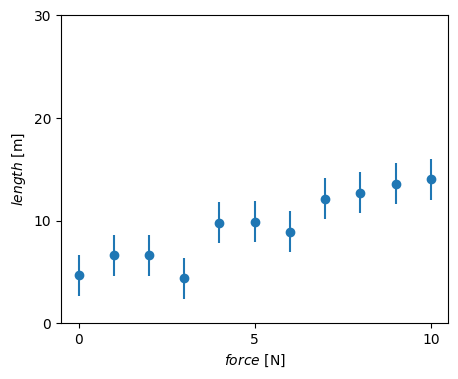

In [22]:
class Data:

    def __init__(self, file_name):
        self.df = pd.read_csv(file_name)

    def plot(self, y_model_true=None, y_model_fit=None):
        plt.figure(figsize=(5, 4))
        plt.errorbar(
            self.df.x,
            self.df.y,
            yerr=self.df.sigma,
            fmt='o'
        )
        if y_model_true:
            plt.plot(self.df.x, y_model_true, c='c')
        if y_model_fit:
            plt.plot(self.df.x, y_model_fit, c='r')
        plt.xlabel('$force$ [N]')
        plt.ylabel('$length$ [m]')
        plt.xticks([0, 5, 10])
        plt.yticks([0, 10, 20, 30])
        plt.savefig('data.png', dpi=100)


data = Data(file_name='results.csv')
data.plot()

In [23]:
def gaussian(x, mu, sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * \
           np.exp(-(x - mu)**2 / (2 * sigma**2))

In [24]:
# def compute_likelihood(y_data_list, y_model_list, sigma_err_list):
#     likelihood = 1
#     for y_data, y_model, sigma_err in zip(y_data_list, y_model_list, sigma_err_list):
#         likelihood_of_one_point = gaussian(x=y_data, mu=y_model, sigma=sigma_err)
#         print(likelihood_of_one_point)
#         likelihood *= likelihood_of_one_point
#     return likelihood


def compute_log_likelihood(y_data_list, y_model_list, sigma_err_list):
    # log_likelihood = np.log10(1)
    log_likelihood = 0
    for y_data, y_model, sigma_err in zip(y_data_list, y_model_list, sigma_err_list):
        likelihood_of_one_point = gaussian(x=y_data, mu=y_model, sigma=sigma_err)
        log_likelihood_of_one_point = np.log10(likelihood_of_one_point)
        log_likelihood += log_likelihood_of_one_point
    return log_likelihood


100%|██████████| 50000/50000 [00:11<00:00, 4274.58it/s]


Acceptance fraction: 0.54048


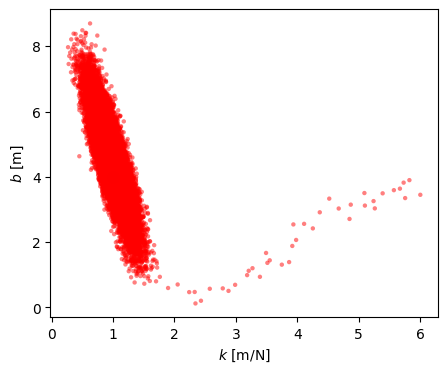

In [80]:
class RandomWalkerOptimizer:

    def __init__(self, data, model):
        self.data = data
        self.model = model
        # grid part
        self.k_list = []
        self.b_list = []
        self.loss_list = []
        # walker part
        self.k_walk_list = []
        self.b_walk_list = []
        self.likelihood_walk_list = []
        self.idx_min = None
        self.num_accepted = 0
        self.num_rejected = 0
        self.seed = 1
        self.rng = np.random.default_rng(self.seed)

    def walk(self, k_start, b_start, num_steps):
        k_now = k_start
        b_now = b_start
        # likelihood_now = 0    # lowest value of 0 to maximize it
        # log_likelihood_now = np.log10(0)
        log_likelihood_now = -np.inf

        for step in tqdm.tqdm(range(num_steps)):
            ratio = 2
            k_step = self.rng.uniform(-0.5 / ratio, 0.5 / ratio)   # TODO finetune
            b_step = self.rng.uniform(-1 / ratio, 1 / ratio)   # TODO

            k_test = k_now + k_step
            b_test = b_now + b_step
            self.model.set_params(k_test, b_test)
            y_model = self.model.evaluate(self.data.df.x)

            log_likelihood_test = compute_log_likelihood(
                y_data_list=self.data.df.y,
                y_model_list=y_model,
                sigma_err_list=self.data.df.sigma,
            )

            if log_likelihood_test - log_likelihood_now > np.log10(np.random.uniform(0, 1)):
                k_now = k_test
                b_now = b_test
                log_likelihood_now = log_likelihood_test
                self.k_walk_list.append(k_now)
                self.b_walk_list.append(b_now)
                self.likelihood_walk_list.append(log_likelihood_now)
                self.num_accepted += 1
            else:
                self.num_rejected += 1

        print('Acceptance fraction:', self.num_accepted / num_steps)

    def plot(self):
        plt.figure(figsize=(5, 4))
        plt.scatter(
            self.k_list,
            self.b_list,
            c=np.sqrt(self.loss_list),
            cmap='tab10',
            s=2,
            marker='s',
            zorder=0
        )
        # model true is cyan
        plt.scatter(
            K_TRUE,
            B_TRUE,
            s=60,
            c='cyan',
            zorder=1
        )
        plt.scatter(
            self.k_walk_list,
            self.b_walk_list,
            c='red',
            zorder=9999,
            alpha=0.5,
            edgecolors='None',
            s=10
        )
        plt.xlabel('$k$ [m/N]')
        plt.ylabel('$b$ [m]')
        # TODO add label for mean squard error units of measurement [m2]
        plt.savefig('param_walk.png', dpi=100)

model_to_fit = Model(k=0, b=0)
optimizer_walker = RandomWalkerOptimizer(data=data, model=model_to_fit)

optimizer_walker.walk(
    k_start=6,
    b_start=3,
    num_steps=50000,
)
optimizer_walker.plot()


Text(0, 0.5, 'k')

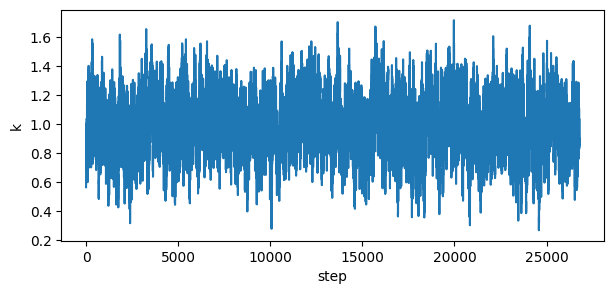

In [81]:
plt.figure(figsize=(7, 3))
# burn-in phase while model is still optimized, in this case 200 steps
num_burnin = 250
plt.plot(optimizer_walker.k_walk_list[num_burnin:])
plt.xlabel('step'); plt.ylabel('k')


np.float64(0.18962875932118922)

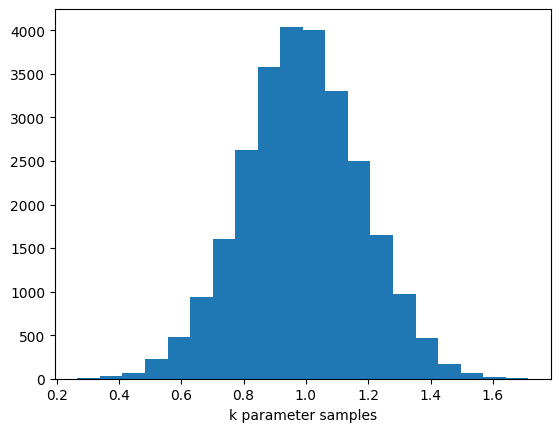

In [82]:
plt.hist(optimizer_walker.k_walk_list[num_burnin:], bins=20);
plt.xlabel('k parameter samples')

k_mean = np.mean(optimizer_walker.k_walk_list[num_burnin:])
k_mean
k_sigma = np.std(optimizer_walker.k_walk_list[num_burnin:])
k_sigma

Text(0.5, 0, 'b parameter samples')

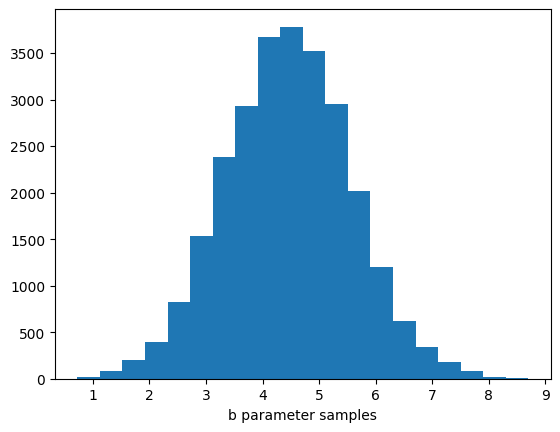

In [83]:
plt.hist(optimizer_walker.b_walk_list[num_burnin:], bins=20);
plt.xlabel('b parameter samples')



In [87]:
!pip install corner

# https://corner.readthedocs.io/en/latest/pages/quickstart/

In [93]:
k = optimizer_walker.k_walk_list[num_burnin:]
b = optimizer_walker.b_walk_list[num_burnin:]

samples = np.stack([k, b], axis=1)
samples.shape

(26774, 2)

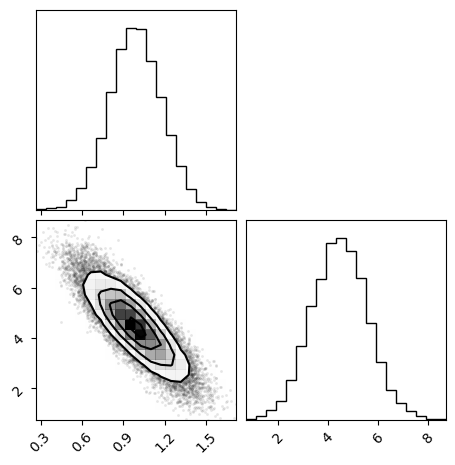

In [94]:
import corner
import numpy as np

figure = corner.corner(samples)

figure = corner.corner(
    data,
    labels=[
        r"$x$",
        r"$y$",
        r"$\log \alpha$",
        r"$\Gamma \, [\mathrm{parsec}]$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [90]:
samples.shape

(10000, 2)